# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


## Installing and importing functions and packages

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
#!pip install missingpy

In [2]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from missingpy import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from brats.load_data import load_data

## Loading and splitting data 

In [3]:
# Load data
data = load_data()

# Splitting feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

GBM = FEATURES.loc[LABELS=='GBM']
LGG = FEATURES.loc[LABELS=='LGG']

# Splitting into train and test set --> dit moet weg
#X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=42)



## Preprocessing before crossvalidation

Overview of the NaN's in the dataset

In [4]:
# Determining the number of NaN's
NO_NAN_ROW_TOTAL = FEATURES.isnull().sum(axis=1)             # Number of NaN's per patient for GBM and LGG patients
NO_NAN_COL_TOTAL = FEATURES.isnull().sum(axis=0)             # Number of NaN's per feature for GBM and LGG patients

GBM_NO_NAN_COL = GBM.isnull().sum(axis=0)                    # Number of NaN's per feature for GBM patients
LGG_NO_NAN_COL = LGG.isnull().sum(axis=0)                    # Number of NaN's per feature for LGG patients
OVERVIEW_NAN = { 'Total': NO_NAN_COL_TOTAL, 'GBM': GBM_NO_NAN_COL, 'LGG': LGG_NO_NAN_COL } 


Feature selection based on the number of NaN's. Threshold = the maximum number of NaN's in a column

In [5]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 30
PERC_MISSING_LGG = 30

# Determining threshold for discarding feature based on above percentage
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be discarded to list

for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
DATA_FEAT_SEL = FEATURES.drop(columns=[features for features in set(FEATURES_REMOVED)])

# The variables (series) below 'bins' the NaN's:
# - the index column is the amount of NaN's in the dataset 
# - the second column is the amount of features that have this amount of NaN's

#aantal_NAN_GBM = GBM_no_nan_col.value_counts()
#aantal_NAN_LGG = LGG_no_nan_col.value_counts()
#aantal_NAN_total = no_nan_col.value_counts()


Patient selection based on the number of NaN's. Threshold = the maximum number of NaN's in a row.

In [6]:
# Patient selection 

# Percentage/number of features that a patient is allowed to miss. When above this amount, this patient is removed from the trainingset, because it is missing too many features. 
PERC_MISSING_SAMPLE = 30

# Make the threshold
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(DATA_FEAT_SEL.columns))

# Number of NaN's per patient AFTER removing some features
NO_NAN_ROW_TRAIN = DATA_FEAT_SEL.isnull().sum(axis=1)      

# Make an empty list, which will be filled with samples that are above the threshold
SAMPLES_REMOVED = [] 
LABELS_SEL = LABELS

# Looping over the trainingset to determine which patients are above the threshold, and remove them directly.
#print('These samples are removed from dataset:')
#for sample in NO_NAN_ROW_TRAIN[NO_NAN_ROW_TRAIN > THRESHOLD_SAMPLE].index[:]:
#    if sample:
#        print(sample)
#        SAMPLES_REMOVED.append(sample)      # This should be removed in combination with the comment before
#        DATA_FEAT_SEL = DATA_FEAT_SEL.drop(index=sample)
#        LABELS_SEL = LABELS_SEL.drop(index=sample)

#print(f'{len(DATA_FEAT_SEL)}/{len(FEATURES)} samples are left in dataset')

Evaluation of data distribution and outliers

In [7]:
# Evaluate data distribution: 
IMPUTER_TOTAL = KNNImputer(n_neighbors=5, weights="uniform")

DATA_TOTAL_IMPUTED = IMPUTER_TOTAL.fit_transform(DATA_FEAT_SEL)

NO_NORM_DISTR = 0
FEAT_NORM = list()
for index, feature in enumerate(DATA_TOTAL_IMPUTED.T):
    t_stat, p_value = shapiro(feature)
    if p_value>0.05:
        NO_NORM_DISTR += 1 
        FEAT_NORM.append(index)



In [8]:

# Evaluate per patient each feature
NO_OUTLIERS = 0

for patient in DATA_TOTAL_IMPUTED:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(DATA_TOTAL_IMPUTED[:,index], 25), np.percentile(DATA_TOTAL_IMPUTED[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS += 1

# Calculate mean and standard deviation per feature based on training data
#MEAN = DATA_TOTAL_IMPUTED.mean(axis=0)
#STD = DATA_TOTAL_IMPUTED.std(axis=0)

# Evaluate per patient each feature
#NO_OUTLIERS = 0
#for patient in DATA_TOTAL_IMPUTED:
#    feat_out = 0
#    for feature, mu, std in zip(patient, MEAN, STD):
#        outlier = ((feature>mu+3*std) | (feature<mu-3*std))
#        feat_out += outlier
#    if feat_out > 30:
#        no_outliers += 1

## Function definitions

In [9]:
# Imputation

def knn_impute_train_set(X_train, y_train, X_test):
    # Definition of imputers
    imputer_gbm = KNNImputer(n_neighbors=5, weights="uniform")
    imputer_lgg = KNNImputer(n_neighbors=5, weights="uniform")        
    imputer_test = KNNImputer(n_neighbors=5, weights="uniform")

    # Impute GBM train set
    X_train_gbm = X_train[y_train=='GBM']        
    X_train_imp_gbm =  imputer_gbm.fit_transform(X_train_gbm)    

    # Impute LGG train set
    X_train_lgg = X_train[y_train=='LGG']        
    X_train_imp_lgg = imputer_lgg.fit_transform(X_train_lgg)    

    # Merge imputed GBM and LGG arrays
    X_train_imp_tot = np.concatenate((X_train_imp_gbm, X_train_imp_lgg))

    # Impute test set 
    imputer_test.fit(X_train_imp_tot)
    X_test_imp = imputer_test.transform(X_test)
    
    return X_train_imp_tot, X_test_imp

In [10]:
# Scaling

def scale_train_and_test_data(X_train, X_test):
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scal = scaler.transform(X_train)
    X_test_scal = scaler.transform(X_test)
    return X_train_scal, X_test_scal

In [11]:
# Feature selection using recursive feature elimination

def select_features_rfecv(X_train, y_train):

    svc = svm.SVC(kernel="linear")
    optimal_number_features = list()

    # classifications
    rfecv = RFECV(
        estimator=svc, step=1, 
        cv=StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_train, y_train)                               

    optimal_number_features.append(rfecv.n_features_)
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    return rfecv.support_
    #print(rfecv.ranking_)
    #np.absolute(rfecv.estimator_.coef_)

In [12]:
#def RandomForest_gridsearch(X_TRAIN_SEL, Y_TRAIN):
#    '''Perform a Grid Search on the training set 
#    to find the optimal hyperparameters.
#    Input: training data and labels
#    Output: Random Forest Classifier with optimal hyperparameters'''

#    model_params = {
#        'n_estimators': [32, 64, 128, 150],
#        'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
#        'min_samples_split': [2, 4, 6],
#        'max_depth': [1,6,15,28,32]
#    }

#    GRID = GridSearchCV(RandomForestClassifier(), model_params, refit=True, verbose=1)
#    GRID.fit(X_TRAIN_SEL, Y_TRAIN)

#    RandomForest_CLASSIFIER = GRID.best_estimator_
#    print(RandomForest_CLASSIFIER)
#    RESULTS = pd.DataFrame(GRID.cv_results_)

#    return RandomForest_CLASSIFIER 


def KNN_gridsearch(X_TRAIN_SEL, Y_TRAIN):
    '''Perform a Grid Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: Random Forest Classifier with optimal hyperparameters'''

    k_range = list(range(3,31))
    weight_options = ["uniform", "distance"]

    param_grid = dict(n_neighbors = k_range, weights = weight_options)

    GRID = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=0)
    GRID.fit(X_train_sel, y_train)

    KNN_CLASSIFIER = GRID.best_estimator_
    print(KNN_CLASSIFIER)
    RESULTS = pd.DataFrame(GRID.cv_results_)

    return KNN_CLASSIFIER 

In [13]:
def svm_gridsearch(X_train_sel, Y_train):
    '''Perform a Grid Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: SVM Classifier with optimal hyperparameters'''

    param_grid =  {'kernel': ['linear', 'rbf', 'poly'],
                    'C': [0.01, 0.1, 1, 10, 100]} 
                    #'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                    #'degree': [1, 2, 3, 4, 5],
                    #'coef0': [0.01, 0.5, 1, 5, 10, 20]} 

    GRID = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
    GRID.fit(X_train_sel, y_train)

    SVM_CLASSIFIER = GRID.best_estimator_
    #print(SVM_CLASSIFIER)
    RESULTS = pd.DataFrame(GRID.cv_results_)

    return SVM_CLASSIFIER

## Crossvalidation 

Optimal number of features : 12


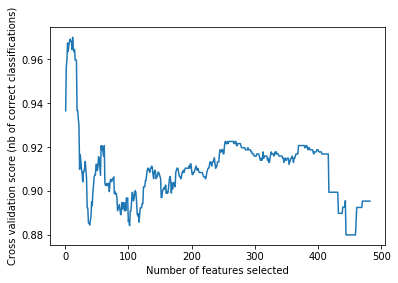

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Optimal number of features : 1


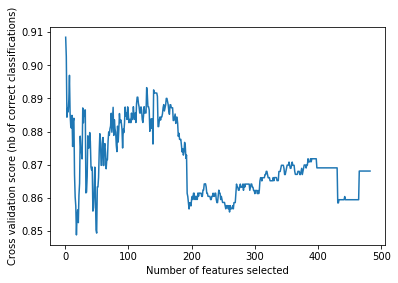

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Optimal number of features : 2


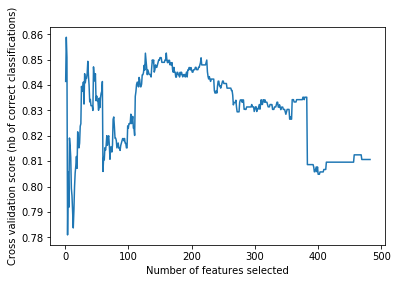

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Optimal number of features : 1


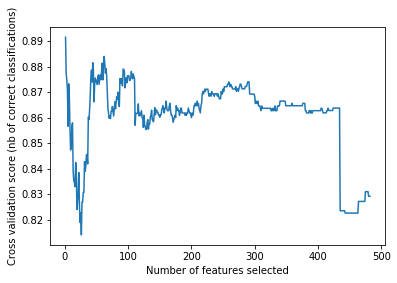

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Optimal number of features : 83


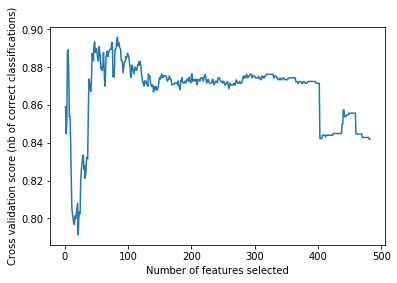

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [14]:
# Outer crossvalidation loop
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


for train_index, test_index in skf.split(DATA_FEAT_SEL, LABELS_SEL):
    X_train, X_test = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    y_train, y_test = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]

    gbm_train = X_train[y_train=='GBM']
    lgg_train = X_train[y_train=='LGG']

    # ---------------------------------- IMPUTATION -----------------------------------

    X_train_imp, X_test_imp = knn_impute_train_set(X_train, y_train, X_test) 
 
    # ------------------------------------ SCALING ----------------------------------------
    X_train_scal, X_test_scal = scale_train_and_test_data(X_train_imp, X_test_imp)

    # ------------------------------------ FEATURE SELECTION -------------------------------
    selected_features = select_features_rfecv(X_train_scal, y_train)
    X_train_sel = X_train_scal[:,selected_features]
    X_test_sel = X_test_scal[:,selected_features]

    # -------------- CLASSIFIERS GRIDSEARCH ---- (uncommand the one you want to try) ----------
    hyperparameter = svm_gridsearch(X_train_sel, y_train)   # Support Vector Machine classifier
    #hyperparameter = KNN_gridsearch(X_train_sel, y_train)  # K Nearnest Neighbour classifier
    #hyperparameter = RF_gridsearch(X_train_sel, y_train)   # Random Forrest classifier
    print(hyperparameter)

    # ------------------ TRAINING THE CLASSIFIER WITH HYPERPARAMETERS ------------------------
    # weet niet precies hoe het moet vanwege dat de dataset in 4en hebben (1x train, 1x test en 2 dingen met labels)
    # op internet vind veel je dingen met cross_val_score, maar binnen die functie splitst ie zelf? 
    # het moet getrained worden op X_train samen met y_train, en dan getest worden op X_test, en gecheckt worden met y_test


In [15]:
#KNN Classification/ hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
X = X_train_sel
y = y_train

k_range = list(range(3,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X,y)

#print(grid.grid_scores_)
'''
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)
'''

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)





knn = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',metric_params=None, n_jobs=1)
knn.fit(X_train_sel, y_train)
#predict the response for test dataset
y_pred = knn.predict(X_test_sel)
from sklearn import metrics 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))





0.8521978021978022
{'n_neighbors': 8, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')
Accuracy: 0.8484848484848485


In [16]:
model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

X= X_train_sel
Y= y_train


# create random forest classifier model
rf_model = RandomForestClassifier(random_state=1)

# set up grid search meta-estimator
clf = GridSearchCV(rf_model, model_params, cv=5)

# train the grid search meta-estimator to find the best model
model = clf.fit(X, y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

predictions = model.predict(X)
print(predictions)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_sel,y_train)
y_pred=clf.predict(X_test_sel)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.75,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
['GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM'
 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'GBM' 'LGG' 'LGG'
 'LGG' 'LGG' 'LGG' 'LGG' 'LGG' 'LGG' 'LGG' 'LGG' 'LGG' '